In [203]:
import pandas as pd
import numpy as np
import random
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import os

import cv2

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

from ipywidgets import widgets, VBox, HBox

from IPython.display import display, clear_output

from PIL import Image, ImageDraw, ImageFont

import base64
from io import BytesIO

from tqdm import tqdm

# Compute Area of Potholes

In [204]:
valid_ids = pd.read_csv('Combined Data/valid_ids.csv')
train_labels = pd.read_csv('Combined Data/train_labels.csv')
train_labels.columns = ['pothole_id', 'bags_used']
train_labels['pothole_id'] = 'p' + train_labels['pothole_id'].astype(str)

### Models

In [205]:
pothole_id_model = YOLO('DONT TOUCH THESE MODELS/pothole_id.pt')
l1_model = YOLO('DONT TOUCH THESE MODELS/l1_id_2.0.pt')
segmentation_model = YOLO('../pandas/Christiaan/YOLO/Segmentation/best.pt')

### Auxiliary Functions

In [206]:
def find_red_centroids_in_bbox(image, bbox):
    x1, y1, x2, y2 = bbox
    cropped_image = image[y1:y2, x1:x2]

    hsv_cropped = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv_cropped, lower_red, upper_red)

    lower_red = np.array([160, 100, 100])
    upper_red = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv_cropped, lower_red, upper_red)

    mask = mask1 + mask2

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    height, width = cropped_image.shape[:2]
    half_width = width // 2
    half_height = height // 2

    left_half_centroids = []
    right_half_centroids = []
    top_half_centroids = []
    bottom_half_centroids = []

    for contour in contours:
        area = cv2.contourArea(contour)
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cX = int(M['m10'] / M['m00'])
            cY = int(M['m01'] / M['m00'])
            
            if height > width:  # Vertical orientation
                if cY < half_height:
                    top_half_centroids.append((cX + x1, cY + y1, area))
                else:
                    bottom_half_centroids.append((cX + x1, cY + y1, area))
            else:  # Horizontal orientation
                if cX < half_width:
                    left_half_centroids.append((cX + x1, cY + y1, area))
                else:
                    right_half_centroids.append((cX + x1, cY + y1, area))

    def select_largest_area(centroids):
        if not centroids:
            return None
        return max(centroids, key=lambda x: x[2])

    if height > width:  # Vertical orientation
        top_centroid = select_largest_area(top_half_centroids)
        bottom_centroid = select_largest_area(bottom_half_centroids)

        if not top_centroid:
            top_centroid = (x1 + width // 2, y1 + int(height * 0.1))

        if not bottom_centroid:
            bottom_centroid = (x1 + width // 2, y2 - int(height * 0.1))

        return [top_centroid, bottom_centroid]
    else:  # Horizontal orientation
        left_centroid = select_largest_area(left_half_centroids)
        right_centroid = select_largest_area(right_half_centroids)

        if not left_centroid:
            left_centroid = (x1 + int(width * 0.1), y1 + height // 2)

        if not right_centroid:
            right_centroid = (x2 - int(width * 0.1), y1 + height // 2)

        return [left_centroid, right_centroid]

def compute_area(image_path, pothole_id_model, l1_model, segmentation_model):
    # Load the image
    image = cv2.imread(image_path)

    # Step 1: Detect the L1 bounding box using the model
    l1_results = l1_model.predict(source=image, save=False, verbose=False)

    if len(l1_results[0].boxes) > 0:
        # Get the bounding box with the highest confidence
        l1_boxes = l1_results[0].boxes.xyxy.cpu().numpy()
        l1_confidences = l1_results[0].boxes.conf.cpu().numpy()
        l1_max_conf_idx = np.argmax(l1_confidences)
        l1_bbox = l1_boxes[l1_max_conf_idx].astype(int)

        # Step 2: Find the red centroids in the L1 bounding box
        red_centroids = find_red_centroids_in_bbox(image, l1_bbox)
        return red_centroids
    else:
        return None

## Main Function

In [209]:
def compute_area_visual(image_path, pothole_id_model, l1_model, segmentation_model, plot_progress=False):
    # Load the image
    image = cv2.imread(image_path)

    # Step 1: Detect the L1 bounding box using the model
    l1_results = l1_model.predict(source=image, save=False, verbose=False, conf=0.01)

    if len(l1_results[0].boxes) > 0:
        # Get the bounding box with the highest confidence
        l1_boxes = l1_results[0].boxes.xyxy.cpu().numpy()
        l1_confidences = l1_results[0].boxes.conf.cpu().numpy()
        l1_max_conf_idx = np.argmax(l1_confidences)
        l1_bbox = l1_boxes[l1_max_conf_idx].astype(int)

        # Step 2: Find the red centroids in the L1 bounding box
        red_centroids = find_red_centroids_in_bbox(image, l1_bbox)
        if red_centroids is None:
            print("No red centroids found.")
            return None, None, None, None
        
        # Step 3: Calculate the pixel-to-mm ratio
        if len(red_centroids) == 2:
            pixel_distance = np.linalg.norm(np.array(red_centroids[0][:2]) - np.array(red_centroids[1][:2]))
            mm_to_pixel_ratio = 500 / pixel_distance if pixel_distance > 0 else None
        else:
            print("Insufficient red centroids found.")
            return None, None, None, None
        
        # Step 4: Detect the pothole bounding box using the pothole model
        pothole_results = pothole_id_model.predict(source=image, save=False, verbose=False, conf=0.001)

        if len(pothole_results[0].boxes) > 0:
            # Get the bounding box with the highest confidence
            pothole_boxes = pothole_results[0].boxes.xyxy.cpu().numpy()
            pothole_confidences = pothole_results[0].boxes.conf.cpu().numpy()
            pothole_max_conf_idx = np.argmax(pothole_confidences)
            pothole_bbox = pothole_boxes[pothole_max_conf_idx].astype(int)

            # Calculate the length and width of the pothole bounding box in pixels
            pothole_length = pothole_bbox[2] - pothole_bbox[0]
            pothole_width = pothole_bbox[3] - pothole_bbox[1]

            # Step 5: Predict the pothole contour using the segmentation model on the entire image
            contour_results = segmentation_model.predict(source=image, conf=0.001, save=False, verbose=False)

            pothole_area_pixels = 0
            if contour_results[0].masks is not None:
                masks = contour_results[0].masks.data.cpu().numpy()
                mask_scores = contour_results[0].boxes.conf.cpu().numpy()
                max_conf_idx = np.argmax(mask_scores)
                best_mask = masks[max_conf_idx]

                # Apply threshold to mask
                mask = (best_mask > 0.5).astype(np.uint8) * 255

                # Resize mask to fit original image scale
                mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))

                # Find contours in the mask
                contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Calculate the area of the contour
                for contour in contours:
                    pothole_area_pixels += cv2.contourArea(contour)

                # Draw contours on the original image
                cv2.drawContours(image, contours, -1, (0, 255, 0), 2)  # Green contours

            if plot_progress:
                # Plot the L1 bounding box, pothole bounding box, red points, and contour
                cv2.rectangle(image, (l1_bbox[0], l1_bbox[1]), (l1_bbox[2], l1_bbox[3]), (255, 0, 0), 2)  # L1 box in blue
                cv2.rectangle(image, (pothole_bbox[0], pothole_bbox[1]), (pothole_bbox[2], pothole_bbox[3]), (0, 255, 255), 2)  # Pothole box in yellow

                for point in red_centroids:
                    if point:
                        cv2.circle(image, point[:2], 5, (0, 0, 255), -1)  # Red dots

                # Convert to RGB for displaying
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Display the image
                plt.figure(figsize=(10, 10))
                plt.imshow(image_rgb)
                plt.axis('off')
                plt.show()

            # Calculate the area in square millimeters
            pothole_area_mm2 = pothole_area_pixels * (mm_to_pixel_ratio ** 2) if mm_to_pixel_ratio else None

            return mm_to_pixel_ratio, pothole_length, pothole_width, pothole_area_mm2
        else:
            print(f"No pothole detected in {os.path.basename(image_path)}.")
            return None, None, None, None
    else:
        print(f"No L1 bounding box detected {os.path.basename(image_path)}.")
        return None, None, None, None

## Not taking Pothole Bounding Box

In [210]:
def compute_area(image_path, l1_model, segmentation_model, plot_progress=False, target_resolution=(1024, 768)):
    # Load the original image
    image = cv2.imread(image_path)
    original_resolution = image.shape[:2]  # (height, width)

    # Step 1: Normalize the image resolution for model processing
    image_normalized = cv2.resize(image, target_resolution)

    # Step 2: Detect the L1 bounding box using the model on the normalized image
    l1_results = l1_model.predict(source=image_normalized, save=False, verbose=False, conf=0.01)

    if len(l1_results[0].boxes) > 0:
        # Get the bounding box with the highest confidence
        l1_boxes = l1_results[0].boxes.xyxy.cpu().numpy()
        l1_confidences = l1_results[0].boxes.conf.cpu().numpy()
        l1_max_conf_idx = np.argmax(l1_confidences)
        l1_bbox_normalized = l1_boxes[l1_max_conf_idx].astype(int)

        # Step 3: Find the red centroids in the L1 bounding box on the normalized image
        red_centroids = find_red_centroids_in_bbox(image_normalized, l1_bbox_normalized)
        if red_centroids is None:
            print("No red centroids found.")
            return None, None
        
        # Step 4: Calculate the pixel-to-mm ratio
        if len(red_centroids) == 2:
            pixel_distance_normalized = np.linalg.norm(np.array(red_centroids[0][:2]) - np.array(red_centroids[1][:2]))
            mm_to_pixel_ratio = 500 / pixel_distance_normalized if pixel_distance_normalized > 0 else None
        else:
            print("Insufficient red centroids found.")
            return None, None
        
        # Step 5: Predict the pothole contour using the segmentation model on the normalized image
        contour_results = segmentation_model.predict(source=image_normalized, save=False, verbose=False)

        pothole_area_pixels = 0
        if contour_results[0].masks is not None:
            masks = contour_results[0].masks.data.cpu().numpy()
            mask_scores = contour_results[0].boxes.conf.cpu().numpy()
            max_conf_idx = np.argmax(mask_scores)
            best_mask = masks[max_conf_idx]

            # Apply threshold to mask
            mask = (best_mask > 0.5).astype(np.uint8) * 255

            # Resize the mask back to the original image scale
            mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))

            # Find contours in the mask resized to the original scale
            contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Calculate the area of the contour
            for contour in contours:
                pothole_area_pixels += cv2.contourArea(contour)

            if pothole_area_pixels == 0:
                print(f"No valid pothole contour area found in {os.path.basename(image_path)}.")
                return None, None

            if plot_progress:
                # Plot the contour on the original image
                cv2.drawContours(image, contours, -1, (0, 255, 0), 2)  # Green contours

                # Convert to RGB for displaying
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Display the image with the pixel ratio and area in cm² as title
                plt.figure(figsize=(10, 10))
                plt.imshow(image_rgb)
                plt.title(f"mm_to_pixel_ratio: {mm_to_pixel_ratio:.2f}, Area: {pothole_area_pixels * (mm_to_pixel_ratio ** 2) / 100:.2f} cm²")
                plt.axis('off')
                plt.show()

        # Calculate the area in square centimeters
        pothole_area_cm2 = (pothole_area_pixels * (mm_to_pixel_ratio ** 2)) / 100 if mm_to_pixel_ratio else None

        return mm_to_pixel_ratio, pothole_area_cm2
    else:
        print(f"No L1 bounding box detected in {os.path.basename(image_path)}.")
        return None, None

# Additional Features

In [12]:
def find_red_centroids_in_bbox(image, bbox):
    x1, y1, x2, y2 = bbox
    cropped_image = image[y1:y2, x1:x2]

    hsv_cropped = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv_cropped, lower_red, upper_red)

    lower_red = np.array([160, 100, 100])
    upper_red = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv_cropped, lower_red, upper_red)

    mask = mask1 + mask2

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    height, width = cropped_image.shape[:2]
    half_width = width // 2
    half_height = height // 2

    left_half_centroids = []
    right_half_centroids = []
    top_half_centroids = []
    bottom_half_centroids = []

    for contour in contours:
        area = cv2.contourArea(contour)
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cX = int(M['m10'] / M['m00'])
            cY = int(M['m01'] / M['m00'])
            
            if height > width:  # Vertical orientation
                if cY < half_height:
                    top_half_centroids.append((cX + x1, cY + y1, area))
                else:
                    bottom_half_centroids.append((cX + x1, cY + y1, area))
            else:  # Horizontal orientation
                if cX < half_width:
                    left_half_centroids.append((cX + x1, cY + y1, area))
                else:
                    right_half_centroids.append((cX + x1, cY + y1, area))

    def select_largest_area(centroids):
        if not centroids:
            return None
        return max(centroids, key=lambda x: x[2])

    if height > width:  # Vertical orientation
        top_centroid = select_largest_area(top_half_centroids)
        bottom_centroid = select_largest_area(bottom_half_centroids)

        if not top_centroid:
            top_centroid = (x1 + width // 2, y1 + int(height * 0.1))

        if not bottom_centroid:
            bottom_centroid = (x1 + width // 2, y2 - int(height * 0.1))

        return [top_centroid, bottom_centroid]
    else:  # Horizontal orientation
        left_centroid = select_largest_area(left_half_centroids)
        right_centroid = select_largest_area(right_half_centroids)

        if not left_centroid:
            left_centroid = (x1 + int(width * 0.1), y1 + height // 2)

        if not right_centroid:
            right_centroid = (x2 - int(width * 0.1), y1 + height // 2)

        return [left_centroid, right_centroid]

def compute_area(image_path, pothole_id_model, l1_model, segmentation_model, plot_progress=False):
    # Load the image
    image = cv2.imread(image_path)

    # Step 1: Detect the L1 bounding box using the model
    l1_results = l1_model.predict(source=image, save=False, verbose=False, conf=0.001)

    if len(l1_results[0].boxes) > 0:
        # Get the bounding box with the highest confidence
        l1_boxes = l1_results[0].boxes.xyxy.cpu().numpy()
        l1_confidences = l1_results[0].boxes.conf.cpu().numpy()
        l1_max_conf_idx = np.argmax(l1_confidences)
        l1_bbox = l1_boxes[l1_max_conf_idx].astype(int)

        # Step 2: Find the red centroids in the L1 bounding box
        red_centroids = find_red_centroids_in_bbox(image, l1_bbox)
        if red_centroids is None:
            print("No red centroids found.")
            return None, None, None, None
        
        # Step 3: Calculate the pixel-to-mm ratio
        if len(red_centroids) == 2:
            pixel_distance = np.linalg.norm(np.array(red_centroids[0][:2]) - np.array(red_centroids[1][:2]))
            mm_to_pixel_ratio = 500 / pixel_distance if pixel_distance > 0 else None
        else:
            print("Insufficient red centroids found.")
            return None, None, None, None
        
        # Step 4: Detect the pothole bounding box using the pothole model
        pothole_results = pothole_id_model.predict(source=image, save=False, verbose=False, conf=0.001)

        if len(pothole_results[0].boxes) > 0:
            # Get the bounding box with the highest confidence
            pothole_boxes = pothole_results[0].boxes.xyxy.cpu().numpy()
            pothole_confidences = pothole_results[0].boxes.conf.cpu().numpy()
            pothole_max_conf_idx = np.argmax(pothole_confidences)
            pothole_bbox = pothole_boxes[pothole_max_conf_idx].astype(int)

            # Calculate the length and width of the pothole bounding box in pixels
            pothole_length_pixels = pothole_bbox[2] - pothole_bbox[0]
            pothole_width_pixels = pothole_bbox[3] - pothole_bbox[1]

            # Convert to millimeters
            pothole_length_mm = pothole_length_pixels * mm_to_pixel_ratio
            pothole_width_mm = pothole_width_pixels * mm_to_pixel_ratio

            # Step 5: Predict the pothole contour using the segmentation model on the entire image
            contour_results = segmentation_model.predict(source=image, conf=0.001, save=False, verbose=False)

            pothole_area_pixels = 0
            if contour_results[0].masks is not None:
                masks = contour_results[0].masks.data.cpu().numpy()
                mask_scores = contour_results[0].boxes.conf.cpu().numpy()
                max_conf_idx = np.argmax(mask_scores)
                best_mask = masks[max_conf_idx]

                # Apply threshold to mask
                mask = (best_mask > 0.5).astype(np.uint8) * 255

                # Resize mask to fit original image scale
                mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))

                # Find contours in the mask
                contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Calculate the area of the contour
                for contour in contours:
                    pothole_area_pixels += cv2.contourArea(contour)

                # Draw contours on the original image
                cv2.drawContours(image, contours, -1, (0, 255, 0), 2)  # Green contours

            if plot_progress:
                # Plot the L1 bounding box, pothole bounding box, red points, and contour
                cv2.rectangle(image, (l1_bbox[0], l1_bbox[1]), (l1_bbox[2], l1_bbox[3]), (255, 0, 0), 2)  # L1 box in blue
                cv2.rectangle(image, (pothole_bbox[0], pothole_bbox[1]), (pothole_bbox[2], pothole_bbox[3]), (0, 255, 255), 2)  # Pothole box in yellow

                for point in red_centroids:
                    if point:
                        cv2.circle(image, point[:2], 5, (0, 0, 255), -1)  # Red dots

                # Convert to RGB for displaying
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Display the image
                plt.figure(figsize=(10, 10))
                plt.imshow(image_rgb)
                plt.axis('off')
                plt.show()

            # Calculate the area in square millimeters
            pothole_area_mm2 = pothole_area_pixels * (mm_to_pixel_ratio ** 2) if mm_to_pixel_ratio else None

            # Additional Feature Engineering
            pothole_aspect_ratio = pothole_length_pixels / pothole_width_pixels if pothole_width_pixels != 0 else None
            pothole_perimeter_pixels = 2 * (pothole_length_pixels + pothole_width_pixels)
            pothole_perimeter_mm = pothole_perimeter_pixels * mm_to_pixel_ratio if mm_to_pixel_ratio else None
            pothole_compactness = pothole_area_pixels / (pothole_perimeter_pixels ** 2) if pothole_perimeter_pixels != 0 else None

            return {
                "mm_to_pixel_ratio": mm_to_pixel_ratio,
                "pothole_length_mm": pothole_length_mm,
                "pothole_width_mm": pothole_width_mm,
                "pothole_area_mm2": pothole_area_mm2,
                "pothole_aspect_ratio": pothole_aspect_ratio,
                "pothole_perimeter_mm": pothole_perimeter_mm,
                "pothole_compactness": pothole_compactness
            }
        else:
            print(f"No pothole detected in {os.path.basename(image_path)}.")
            return None, None, None, None
    else:
        print(f"No L1 bounding box detected {os.path.basename(image_path)}.")
        return None, None, None, None

# Creating Dataframes

### Train Images

In [211]:
train_images_dir = 'Combined Data/train_images'
test_images_dir = '../../data/Patch Perfect Data/test_images'

# Assuming valid_ids is already defined as a list of valid pothole_ids
train_data = []
test_data = []
test_none_data = []

# Process train images
for image_name in tqdm(os.listdir(train_images_dir)):
    pothole_id = os.path.splitext(image_name)[0]
    
    if pothole_id in valid_ids['pothole_id'].values:
        image_path = os.path.join(train_images_dir, image_name)
        mm_to_pixel_ratio, area_mm2 = compute_area(image_path, l1_model, segmentation_model, plot_progress=False)
        
        # Only add to train_data if none of the values are None
        if None not in [mm_to_pixel_ratio, area_mm2]:
            train_data.append({
                'pothole_id': pothole_id,
                'mm_to_pixel_ratio': mm_to_pixel_ratio,
                'pothole_area_mm2': area_mm2
            })

train_df = pd.DataFrame(train_data)
print("Train DataFrame created successfully.")

100%|█████████████████████████████████████████| 978/978 [02:02<00:00,  7.98it/s]

Train DataFrame created successfully.


In [212]:
train_df = train_df.merge(train_labels[['pothole_id', 'bags_used']], on='pothole_id', how='left')

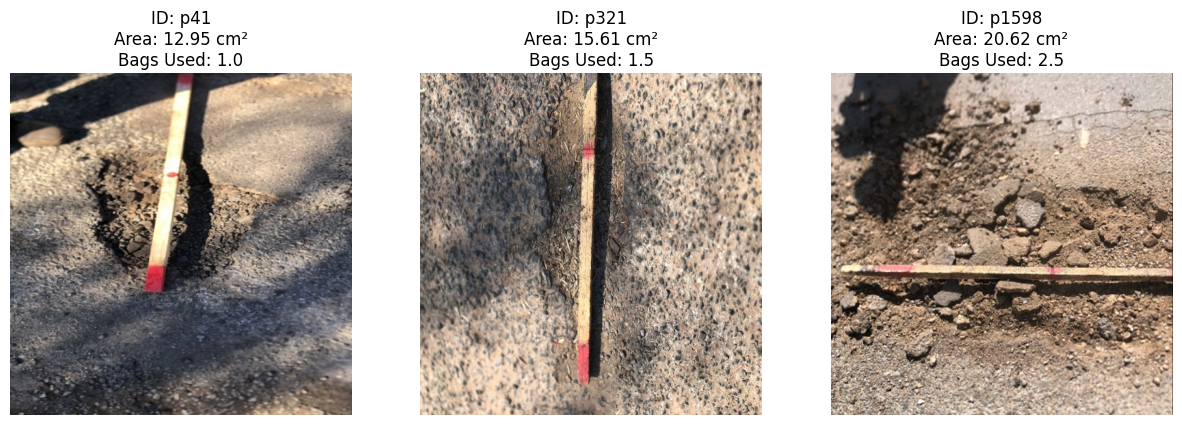

In [214]:
import matplotlib.pyplot as plt
import random
import cv2

# Set a common resolution for all images (e.g., 500x500)
common_resolution = (500, 500)

# Sample 3 random images from the train_df DataFrame
sample_images = train_df.sample(3)

# Initialize a plot
plt.figure(figsize=(15, 5))

for i, row in enumerate(sample_images.itertuples(), 1):
    # Load the image
    image_path = os.path.join(train_images_dir, f"{row.pothole_id}.jpg")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Resize the image to the common resolution
    resized_image = cv2.resize(image, common_resolution)

    # Convert area from mm² to cm² (1 cm² = 100 mm²)
    area_cm2 = row.pothole_area_mm2 / 100 if row.pothole_area_mm2 else 0

    # Plot the resized image
    plt.subplot(1, 3, i)
    plt.imshow(resized_image)
    plt.title(f"ID: {row.pothole_id}\nArea: {area_cm2:.2f} cm²\nBags Used: {row.bags_used}")
    plt.axis('off')

# Show the plot
plt.show()

### For additional features code!!!

In [ ]:
train_images_dir = 'Combined Data/train_images'
test_images_dir = '../../data/Patch Perfect Data/test_images'

# Assuming valid_ids is already defined as a list of valid pothole_ids
train_data = []
test_data = []
test_none_data = []

# Process train images
for image_name in tqdm(os.listdir(train_images_dir)):
    pothole_id = os.path.splitext(image_name)[0]
    
    if pothole_id in valid_ids['pothole_id'].values:
        image_path = os.path.join(train_images_dir, image_name)
        
        # Compute area and other features using the updated compute_area function
        features = compute_area(image_path, pothole_id_model, l1_model, segmentation_model, plot_progress=False)
        
        # Only add to train_data if none of the features are None
        if features and all(value is not None for value in features.values()):
            train_data.append({
                'pothole_id': pothole_id,
                'mm_to_pixel_ratio': features['mm_to_pixel_ratio'],
                'pothole_length_mm': features['pothole_length_mm'],
                'pothole_width_mm': features['pothole_width_mm'],
                'pothole_area_mm2': features['pothole_area_mm2'],
                'pothole_aspect_ratio': features['pothole_aspect_ratio'],
                'pothole_perimeter_mm': features['pothole_perimeter_mm'],
                'pothole_compactness': features['pothole_compactness']
            })

# Convert the collected data to a DataFrame
train_df = pd.DataFrame(train_data)
print("Train DataFrame created successfully.")

In [ ]:
train_df.shape

### Test Images

In [215]:
# Process test images
for image_name in os.listdir(test_images_dir):
    pothole_id = os.path.splitext(image_name)[0]
    
    image_path = os.path.join(test_images_dir, image_name)
    mm_to_pixel_ratio, area_mm2 = compute_area(image_path, l1_model, segmentation_model, plot_progress=False)
    
    if mm_to_pixel_ratio is not None:
        test_data.append({
            'pothole_id': pothole_id,
            'mm_to_pixel_ratio': mm_to_pixel_ratio,
            'pothole_area_mm2': area_mm2
        })
    else:
        test_none_data.append({
            'pothole_id': pothole_id,
            'mm_to_pixel_ratio': None,
            'pothole_area_mm2': None
        })

test_df = pd.DataFrame(test_data)
test_none_df = pd.DataFrame(test_none_data)

print("Test DataFrame created successfully.")
if not test_none_df.empty:
    print("Some test images returned None values. These have been stored in test_none_df.")

Test DataFrame created successfully.


### For additional features code!!!!

In [ ]:
# Process test images
for image_name in tqdm(os.listdir(test_images_dir)):
    pothole_id = os.path.splitext(image_name)[0]

    image_path = os.path.join(test_images_dir, image_name)
    
    # Compute area and other features using the updated compute_area function
    features = compute_area(image_path, pothole_id_model, l1_model, segmentation_model, plot_progress=False)

    # Only add to test_data if none of the features are None
    if features and all(value is not None for value in features.values()):
        test_data.append({
            'pothole_id': pothole_id,
            'mm_to_pixel_ratio': features['mm_to_pixel_ratio'],
            'pothole_length_mm': features['pothole_length_mm'],
            'pothole_width_mm': features['pothole_width_mm'],
            'pothole_area_mm2': features['pothole_area_mm2'],
            'pothole_aspect_ratio': features['pothole_aspect_ratio'],
            'pothole_perimeter_mm': features['pothole_perimeter_mm'],
            'pothole_compactness': features['pothole_compactness']
        })
    else:
        test_none_data.append({
            'pothole_id': pothole_id,
            'mm_to_pixel_ratio': None,
            'pothole_length_mm': None,
            'pothole_width_mm': None,
            'pothole_area_mm2': None,
            'pothole_aspect_ratio': None,
            'pothole_perimeter_mm': None,
            'pothole_compactness': None
        })

# Convert the collected data to DataFrames
test_df = pd.DataFrame(test_data)
test_none_df = pd.DataFrame(test_none_data)

print("Test DataFrame created successfully.")
if not test_none_df.empty:
    print("Some test images returned None values. These have been stored in test_none_df.")

In [216]:
test_df.shape

(30, 3)

In [217]:
#train_df = train_df.merge(train_labels[['pothole_id', 'bags_used']], on='pothole_id', how='left')

In [218]:
train_df = train_df[train_df['pothole_area_mm2']!=0]

In [219]:
test_df[test_df['pothole_area_mm2']==0]

,pothole_id,mm_to_pixel_ratio,pothole_area_mm2


In [221]:
train_df.to_csv('Combined Data/train_df.csv', index=False)
test_df.to_csv('Combined Data/test_df.csv', index=False)

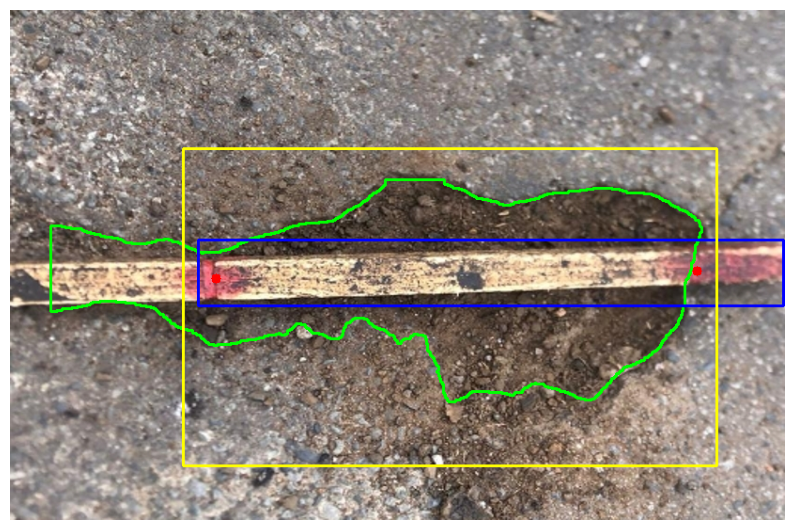

(0.9764433125338822, 568, 337, 92361.31239321455)

In [198]:
compute_area_visual('Combined Data/train_images/p1592.jpg', pothole_id_model, l1_model, segmentation_model, plot_progress=True)

# Testing new cases

In [201]:
def compute_area_visual(image_path, pothole_id_model, l1_model, segmentation_model, plot_progress=False):
    # Load the image
    image = cv2.imread(image_path)

    contour_results = segmentation_model.predict(source=image, save=False, verbose=False)

    if contour_results[0].masks is not None:
        masks = contour_results[0].masks.data.cpu().numpy()
        mask_scores = contour_results[0].boxes.conf.cpu().numpy()
        max_conf_idx = np.argmax(mask_scores)

        # Iterate over all detected masks
        all_contours = []
        for mask in masks:
            # Apply threshold to each mask
            binary_mask = (mask > 0.5).astype(np.uint8) * 255

            # Resize mask to fit original image scale
            mask_resized = cv2.resize(binary_mask, (image.shape[1], image.shape[0]))

            # Find contours in the mask
            mask_contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Calculate the area of the contour
            for contour in mask_contours:
                cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)  # Green contours

            all_contours.extend(mask_contours)

    else:
        print(f"No pothole contour detected in {os.path.basename(image_path)}.")

    # Plot the results if requested
    if plot_progress:
        # Convert to RGB for displaying
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image with contours only
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

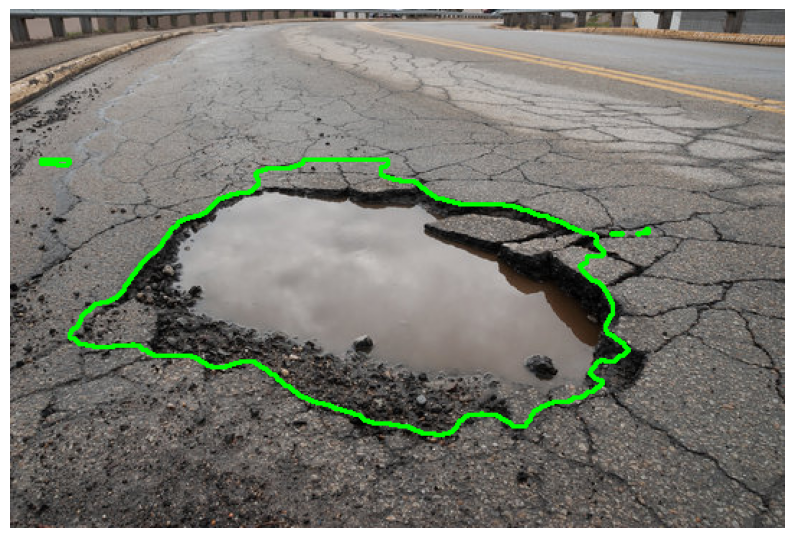

In [202]:
compute_area_visual('../../Report/New cases/test1.jpg', pothole_id_model, l1_model, segmentation_model, plot_progress=True)